# Quick Start with AAanalysis
Dive into the powerful capabilities of **AAanalysis**—a Python framework dedicated to sequence-based, alignment-free protein prediction. In this tutorial, using gamma-secretase substrates and non-substrates as an example, we'll focus on extracting interpretable features from protein sequences using the ``AAclust`` and ``CPP`` models and how they can be harnessed for binary classification tasks.

## What You Will Learn:

1. **Loading Sequences and Scales**: How to easily load protein sequences and their amino acid scales.
2. **Feature Engineering**: Extract essential features using the ``AAclust`` and ``CPP`` models.
3. **Protein Prediction**: Make predictions using the RandomForest model.
4. **Explainable AI**: Interpret predictions at the group and individual levels by combining ``CPP`` with ``SHAP``.

## 1. Loading Sequences and Scales
With AAanalysis, you have access to numerous benchmark datasets for protein sequence analysis. Using our γ-secretase substrates and non-substrates dataset as a hands-on example, you can effortlessly retrieve these datasets using the ``aa.load_dataset()`` function. Furthermore, amino acid scales, predominantly from AAindex, along with their hierarchical classification (known as ``AAontology``), are available at your fingertips with the ``aa.load_scales()`` function.

We now load the scales dataset and a dataset of 50 γ-secretase substrates and non-substrates:

In [10]:
import aaanalysis as aa

df_scales = aa.load_scales()
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)

## 2.  Feature Engineering
The centerpiece of AAanalysis is the Comparative Physicochemical Profiling (``CPP``) model, which is supported by ``AAclust`` for the pre-selection of amino acid scales. 

### AAclust
Since redundancy is an essential problem for machine learning tasks, the ``AAclust`` object provides a lightweight wrapper for sklearn clustering algorithms such as Agglomerative clustering. AAclust clusters a set of scales and selects for each cluster the most representative scale (i.e., the scale closes to the cluster center). We will use AAclust to obtain a set of 100 scales, as defined by the ``n_clusters`` parameters:

In [11]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

aac = aa.AAclust(model=AgglomerativeClustering)
X = np.array(df_scales)
scales = aac.fit(X, names=list(df_scales), n_clusters=100) 
df_scales = df_scales[scales]

### Comparative Physicochemical Profiling (CPP)
 CPP is a sequence-based feature engineering algorithm. It aims at identifying a set of features most discriminant between two sets of sequences: the test set and the reference set. Supported by the ``SequenceFeature`` object (``sf``), A CPP feature integrates:
- **Parts**: Are combination of a target middle domain (TMD) and N- and C-terminal adjacent regions (JMD-N and JMD-C, respectively), obtained ``sf.get_df_parts``.
- **Splits**: These Parts can be split into various continuous segments or discontinuous patterns, specified ``sf.get_split_kws()``. 
- **Scales**: Sets of amino acid scales.

We use SequenceFeature to obtain Parts and Splits. These together with the Scales are used by CPP as input to identify the set of characteristic features to discriminate between γ-secretase substrates and non-substrates: 

In [12]:
y = list(df_seq["label"])
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd_jmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])

Running the CPP algorithm creates all Part, Split, Split combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP to compute the average values for the 100 selected scales over the entire TMD-JMD sequences:

In [13]:
# Small set of CPP features (100 features are created)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws, verbose=False)
df_feat = cpp.run(labels=y) 

## 3. Protein Prediction
A feature matrix from a given set of CPP features can be created using ``sf.feat_matrix`` and used for machine learning:

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, y, scoring="accuracy")
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.57


Creating more features with CPP will take some more time. but improve prediction performance: 

In [15]:
# CPP features with default splits (around 100.000 features)
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, verbose=False)
df_feat = cpp.run(labels=y)

Which can be again used for machine learning:

Mean accuracy of 0.9


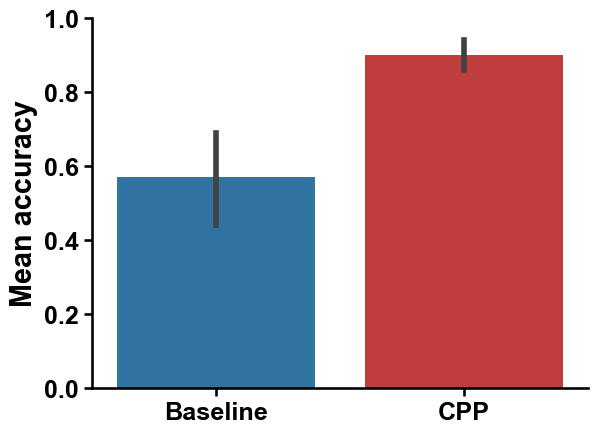

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X = sf.feat_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=1) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

aa.plot_settings(font_scale=1.1)
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
sns.despine()
plt.show()

## 4. Explainable AI

### Explainable AI on group level

### Explainable AI on individual level